# Rent Burden in LA County 2022
For this assignment I will be exploring a relevant variable to eviction rates in LA, namely gross rent as percentage of income (GRAPI). I'll be interested in seeing eventually how rent burden contributes to eviction rates if at all. It would also be interesting to see how rent burden may be in

In [1]:
# import required packages
import pandas as pd
import geopandas as gpd
import numpy as np
import folium
import statistics
import matplotlib.pyplot as plt
import glob
import os

## Load and Process datasets
I'll create a list to hold the year values, then I'll load all the data files into a dataframe list. Then I'll merge them all together with concat().

In [2]:
years=[]
for i in range(2010,2023): 
    years.append(i)

years

[2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]

In [3]:
df_list = []
for i in years:
    df = pd.read_csv('data/DP04_datasets/ACSDP5Y'+str(i)+'.DP04-Data.csv',
                     low_memory=False,
                     dtype={'FIPS':str})
    df_list.append(df)

In [5]:
df_list[5].head()

,FIPS,DP04_0001E,DP04_0001M,DP04_0001PE,DP04_0001PM,DP04_0002E,DP04_0002M,DP04_0002PE,DP04_0002PM,DP04_0003E,...,DP04_0141PE,DP04_0141PM,DP04_0142E,DP04_0142M,DP04_0142PE,DP04_0142PM,DP04_0143E,DP04_0143M,DP04_0143PE,DP04_0143PM
0,06037101110,1757,24,1757,(X),1645,75,93.6,4.2,112,...,19.3,9,423,107,53.8,9.8,95,64,(X),(X)
1,06037101122,1374,22,1374,(X),1218,80,88.6,5.5,156,...,0,16.1,78,50,42.4,22.5,9,14,(X),(X)
2,06037101210,2362,55,2362,(X),2299,89,97.3,2.9,63,...,8.8,5.1,848,189,46,9.6,110,79,(X),(X)
3,06037101220,1256,55,1256,(X),1164,81,92.7,4.6,92,...,16.7,8.8,397,94,56.2,10.6,30,33,(X),(X)
4,06037101300,1570,34,1570,(X),1535,46,97.8,2.3,35,...,30.4,24.5,79,55,40.7,23.8,23,27,(X),(X)


In [5]:
for i in range(len(df_list)):
    df_list[i]['year'] = pd.to_datetime(str(i+2010))

Now I want to add a column to each dataframe indicating the year it's from so that I could use this time data later on. I also want to merge all the years into one dataframe to make analyses based on time. I could still use the individual year dataframes later.

Time to rename all the columns associated with our variable of interest, Gross Rent as Percentage of Income. There are two sets of variables, one represented as percentages and one as total counts. I'll create labels for each set.

In [6]:
for i in df_list:
    i = i.rename(columns={
    'DP04_0137PE':'GRAPI_less_15p',
    'DP04_0138PE':'GRAPI_15_19p',
    'DP04_0139PE':'GRAPI_20_24p',
    'DP04_0140PE':'GRAPI_25_29p',
    'DP04_0141PE':'GRAPI_30_34p',
    'DP04_0142PE':'GRAPI_more_35p',
    'DP04_0137E':'GRAPI_less_15',
    'DP04_0138E':'GRAPI_15_19',
    'DP04_0139E':'GRAPI_20_24',
    'DP04_0140E':'GRAPI_25_29',
    'DP04_0141E':'GRAPI_30_34',
    'DP04_0142E':'GRAPI_more_35'
    },
                inplace=True)

In [7]:
df_list[3].head()

,FIPS,DP04_0001E,DP04_0001M,DP04_0001PE,DP04_0001PM,DP04_0002E,DP04_0002M,DP04_0002PE,DP04_0002PM,DP04_0003E,...,DP04_0139PM,GRAPI_25_29,DP04_0140M,GRAPI_25_29p,DP04_0140PM,GRAPI_30_34,DP04_0141M,GRAPI_30_34p,DP04_0141PM,year
0,06037101110,1757,17,1757,(X),1682,70,95.7,3.9,75,...,9.9,359,131,51.2,14.3,122,79,(X),(X),2013-01-01
1,06037101122,1356,56,1356,(X),1228,87,90.6,5.9,128,...,18.2,91,62,52.6,25.3,10,15,(X),(X),2013-01-01
2,06037101210,2352,49,2352,(X),2216,98,94.2,3.6,136,...,2.6,823,167,45.7,9.1,91,75,(X),(X),2013-01-01
3,06037101220,1282,49,1282,(X),1167,75,91,4.3,115,...,6.5,378,89,54.3,9.6,47,45,(X),(X),2013-01-01
4,06037101300,1571,49,1571,(X),1529,67,97.3,3.1,42,...,25,34,33,15.2,15.3,54,47,(X),(X),2013-01-01


I needed a way to get rid of all of the columns that were unnecessary across all the dataframes so I modified this function I found [here](https://stackoverflow.com/questions/67280834/how-to-iterate-over-a-list-of-dataframes-in-pandas). It will take a dataframe as its argument, loop through the columns and stores all the columns that start with DP04 into a variable "cols". It will then drop all the columns stored in this variable.

In [8]:
def dropnongrapicols(df):    
    cols = [col for col in df.columns if (col.startswith('DP04'))]
    df.drop(cols, axis=1, inplace=True)


Now to call the function, I loop through the series of dataframes for each year with the function previously defined.

In [9]:
for i in df_list:
    dropnongrapicols(i)

In [10]:
df_list[0].sample(20)

,FIPS,GRAPI_less_15,GRAPI_less_15p,GRAPI_15_19,GRAPI_15_19p,GRAPI_20_24,GRAPI_20_24p,GRAPI_25_29,GRAPI_25_29p,GRAPI_30_34,GRAPI_30_34p,year
4,06037101300,0,0,41,28.7,44,30.8,50,35,48,(X),2010-01-01
884,06037270200,104,13.7,197,26,34,4.5,298,39.3,30,(X),2010-01-01
1839,06037571000,29,15,23,11.9,38,19.7,58,30.1,0,(X),2010-01-01
1218,06037407602,0,0,19,7.4,0,0,198,76.7,22,(X),2010-01-01
650,06037218300,140,10.3,154,11.3,56,4.1,836,61.2,39,(X),2010-01-01
1347,06037460700,0,0,27,47.4,0,0,0,0,14,(X),2010-01-01
935,06037278102,116,13.7,93,11,62,7.3,259,30.7,0,(X),2010-01-01
2335,06037980023,0,-,0,-,0,-,0,-,0,(X),2010-01-01
606,06037212501,89,11,258,31.9,66,8.2,262,32.4,36,(X),2010-01-01
207,06037125310,91,7.7,96,8.1,108,9.2,680,57.7,23,(X),2010-01-01


I also realize I have to convert all the columns except for FIPS and year to string. There might be a better way but this is what I came up with after a lot of trial and error.

In [11]:
for i in range(12):
    df_list[i]['GRAPI_less_15p'] = pd.to_numeric(df_list[i]['GRAPI_less_15p'], errors='coerce')
    df_list[i]['GRAPI_15_19p'] = pd.to_numeric(df_list[i]['GRAPI_15_19p'], errors='coerce')
    df_list[i]['GRAPI_20_24p'] = pd.to_numeric(df_list[i]['GRAPI_20_24p'], errors='coerce')
    df_list[i]['GRAPI_25_29p'] = pd.to_numeric(df_list[i]['GRAPI_25_29p'], errors='coerce')
    df_list[i]['GRAPI_30_34p'] = pd.to_numeric(df_list[i]['GRAPI_30_34p'], errors='coerce')
    df_list[i]['GRAPI_more_35p'] = pd.to_numeric(df_list[i]['GRAPI_more_35p'], errors='coerce')
df_list[0].head()

KeyError: 'GRAPI_more_35p'

In [13]:
df_housing_chara_all = pd.concat(df_list, axis=0)
df_list.append(df_housing_chara_all)

In [14]:
df_list[0].head()

,FIPS,GRAPI_less_15,GRAPI_less_15p,GRAPI_15_19,GRAPI_15_19p,GRAPI_20_24,GRAPI_20_24p,GRAPI_25_29,GRAPI_25_29p,GRAPI_30_34,GRAPI_30_34p,GRAPI_more_35,GRAPI_more_35p,year
0,06037101110,8,1.0,157,19.0,38,4.6,115,13.9,66,8.0,441,53.5,2010-01-01
1,06037101122,0,0.0,46,33.3,16,11.6,0,0.0,27,19.6,49,35.5,2010-01-01
2,06037101210,159,9.3,127,7.4,176,10.3,195,11.4,124,7.2,931,54.4,2010-01-01
3,06037101220,14,2.1,95,14.0,90,13.3,86,12.7,25,3.7,368,54.3,2010-01-01
4,06037101300,8,5.6,0,0.0,0,0.0,41,28.7,44,30.8,50,35.0,2010-01-01


Yay!! Now I have a series of dataframes representing the data at each year AND a combined dataframe with all of the years listed as a separate column.

## How has rent burden changed over time?

I want to visualize how rent burden has changed over time by plotting each group over time. 

### Calculations from data
To calculate the means for each group, I'll loop through the series I created for the relevant years at the top and and then use the mean function to calculate the means of every numeric column. I tried doing it without the numeric only argument but kept getting errors due to the FIPS and year columns being str and datetime, respectively. I then save these new values in a list whose indices are the group of means each year

In [15]:
list_grapi_totalmean = []
for i in range(len(years)):
    list_grapi_totalmean.append(df_list[i].mean(numeric_only=True))
list_grapi_totalmean

[GRAPI_less_15      64.006820
 GRAPI_less_15p      9.525781
 GRAPI_15_19        72.192242
 GRAPI_15_19p       10.410720
 GRAPI_20_24        79.424126
 GRAPI_20_24p       11.837023
 GRAPI_25_29        79.563512
 GRAPI_25_29p       11.651780
 GRAPI_30_34        61.498721
 GRAPI_30_34p        9.073828
 GRAPI_more_35     323.025575
 GRAPI_more_35p     47.500825
 dtype: float64,
 GRAPI_less_15      61.559676
 GRAPI_less_15p      9.033752
 GRAPI_15_19        69.710997
 GRAPI_15_19p        9.977340
 GRAPI_20_24        78.873828
 GRAPI_20_24p       11.438432
 GRAPI_25_29        79.851236
 GRAPI_25_29p       11.710225
 GRAPI_30_34        62.222080
 GRAPI_30_34p        9.133709
 GRAPI_more_35     331.871270
 GRAPI_more_35p     48.708795
 dtype: float64,
 GRAPI_less_15      59.609974
 GRAPI_less_15p      8.609209
 GRAPI_15_19        69.008951
 GRAPI_15_19p        9.843882
 GRAPI_20_24        78.788150
 GRAPI_20_24p       11.405361
 GRAPI_25_29        78.824382
 GRAPI_25_29p       11.409511
 GRAPI

Now I'm going to save the means as a dataframe and separate the values into counts and percent

In [16]:
df_grapi_totalmean = pd.DataFrame(list_grapi_totalmean)

df_grapi_count = df_grapi_totalmean[[
    'GRAPI_less_15',
    'GRAPI_15_19',
    'GRAPI_20_24',
    'GRAPI_25_29',
    'GRAPI_30_34',
    'GRAPI_more_35'
]]


df_grapi_pct = df_grapi_totalmean[[
    'GRAPI_less_15p',
    'GRAPI_15_19p',
    'GRAPI_20_24p',
    'GRAPI_25_29p',
    'GRAPI_30_34p',
    'GRAPI_more_35p'
]]

### Graph change per group over time
Now use these dataframes to visualize the change in counts of each group by year. I'm including two graphs representing the same data as percents and then as counts.

<Axes: title={'center': 'Rental Burden by count in LA County from 2010-2022'}>

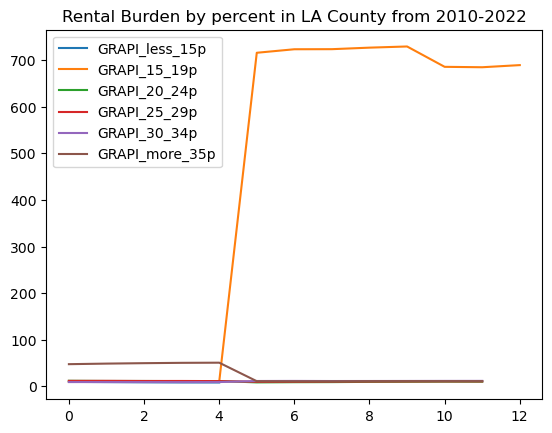

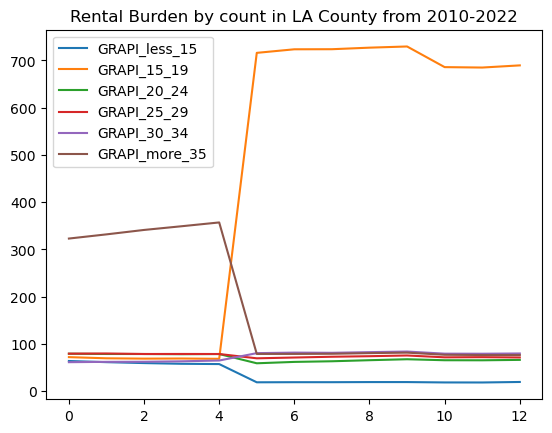

In [17]:
df_grapi_pct.plot(title='Rental Burden by percent in LA County from 2010-2022')
df_grapi_count.plot(title='Rental Burden by count in LA County from 2010-2022')

I wonder what happened between 2014 and 2016 that led to such a dramatic decrease in rent burden.

## Mapping rental burden for 2018-2022

First I want to read in a geojson file of the census tracts as of 2020

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


<Axes: >

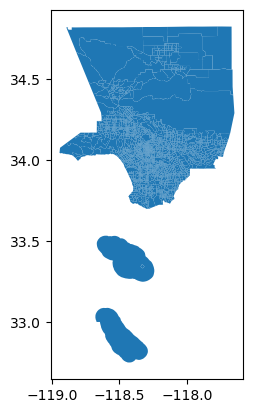

In [18]:
# read in a geojson file downloaded from the LA Times
tracts=gpd.read_file('data/Census_Tracts_2020.geojson')
tracts.plot()

### Process the data

In [19]:
tracts['FIPS'] = (
    '06037' + tracts.CT20
)
tracts_trimmed = tracts[['FIPS', 'geometry']]
tracts_trimmed.head()

,FIPS,geometry
0,06037101110,"POLYGON ((-118.28491 34.25948, -118.28492 34.2..."
1,06037101122,"POLYGON ((-118.29015 34.27417, -118.29015 34.2..."
2,06037101220,"POLYGON ((-118.28100 34.25592, -118.28198 34.2..."
3,06037101221,"POLYGON ((-118.28735 34.25591, -118.28863 34.2..."
4,06037101222,"POLYGON ((-118.28594 34.25405, -118.28594 34.2..."


Time to store the merged dataframes in a list of all tract years

In [28]:
s_housing_chara_tracts = []
for i in range(len(years)): 
    s_housing_chara_tracts.append(tracts_trimmed.merge(df_list[i],on='FIPS'))

In [29]:
len(s_housing_chara_tracts)

13

And now finally to map the density of households paying more than 35% of their income on gross rent by census tract for the years 2019-2022

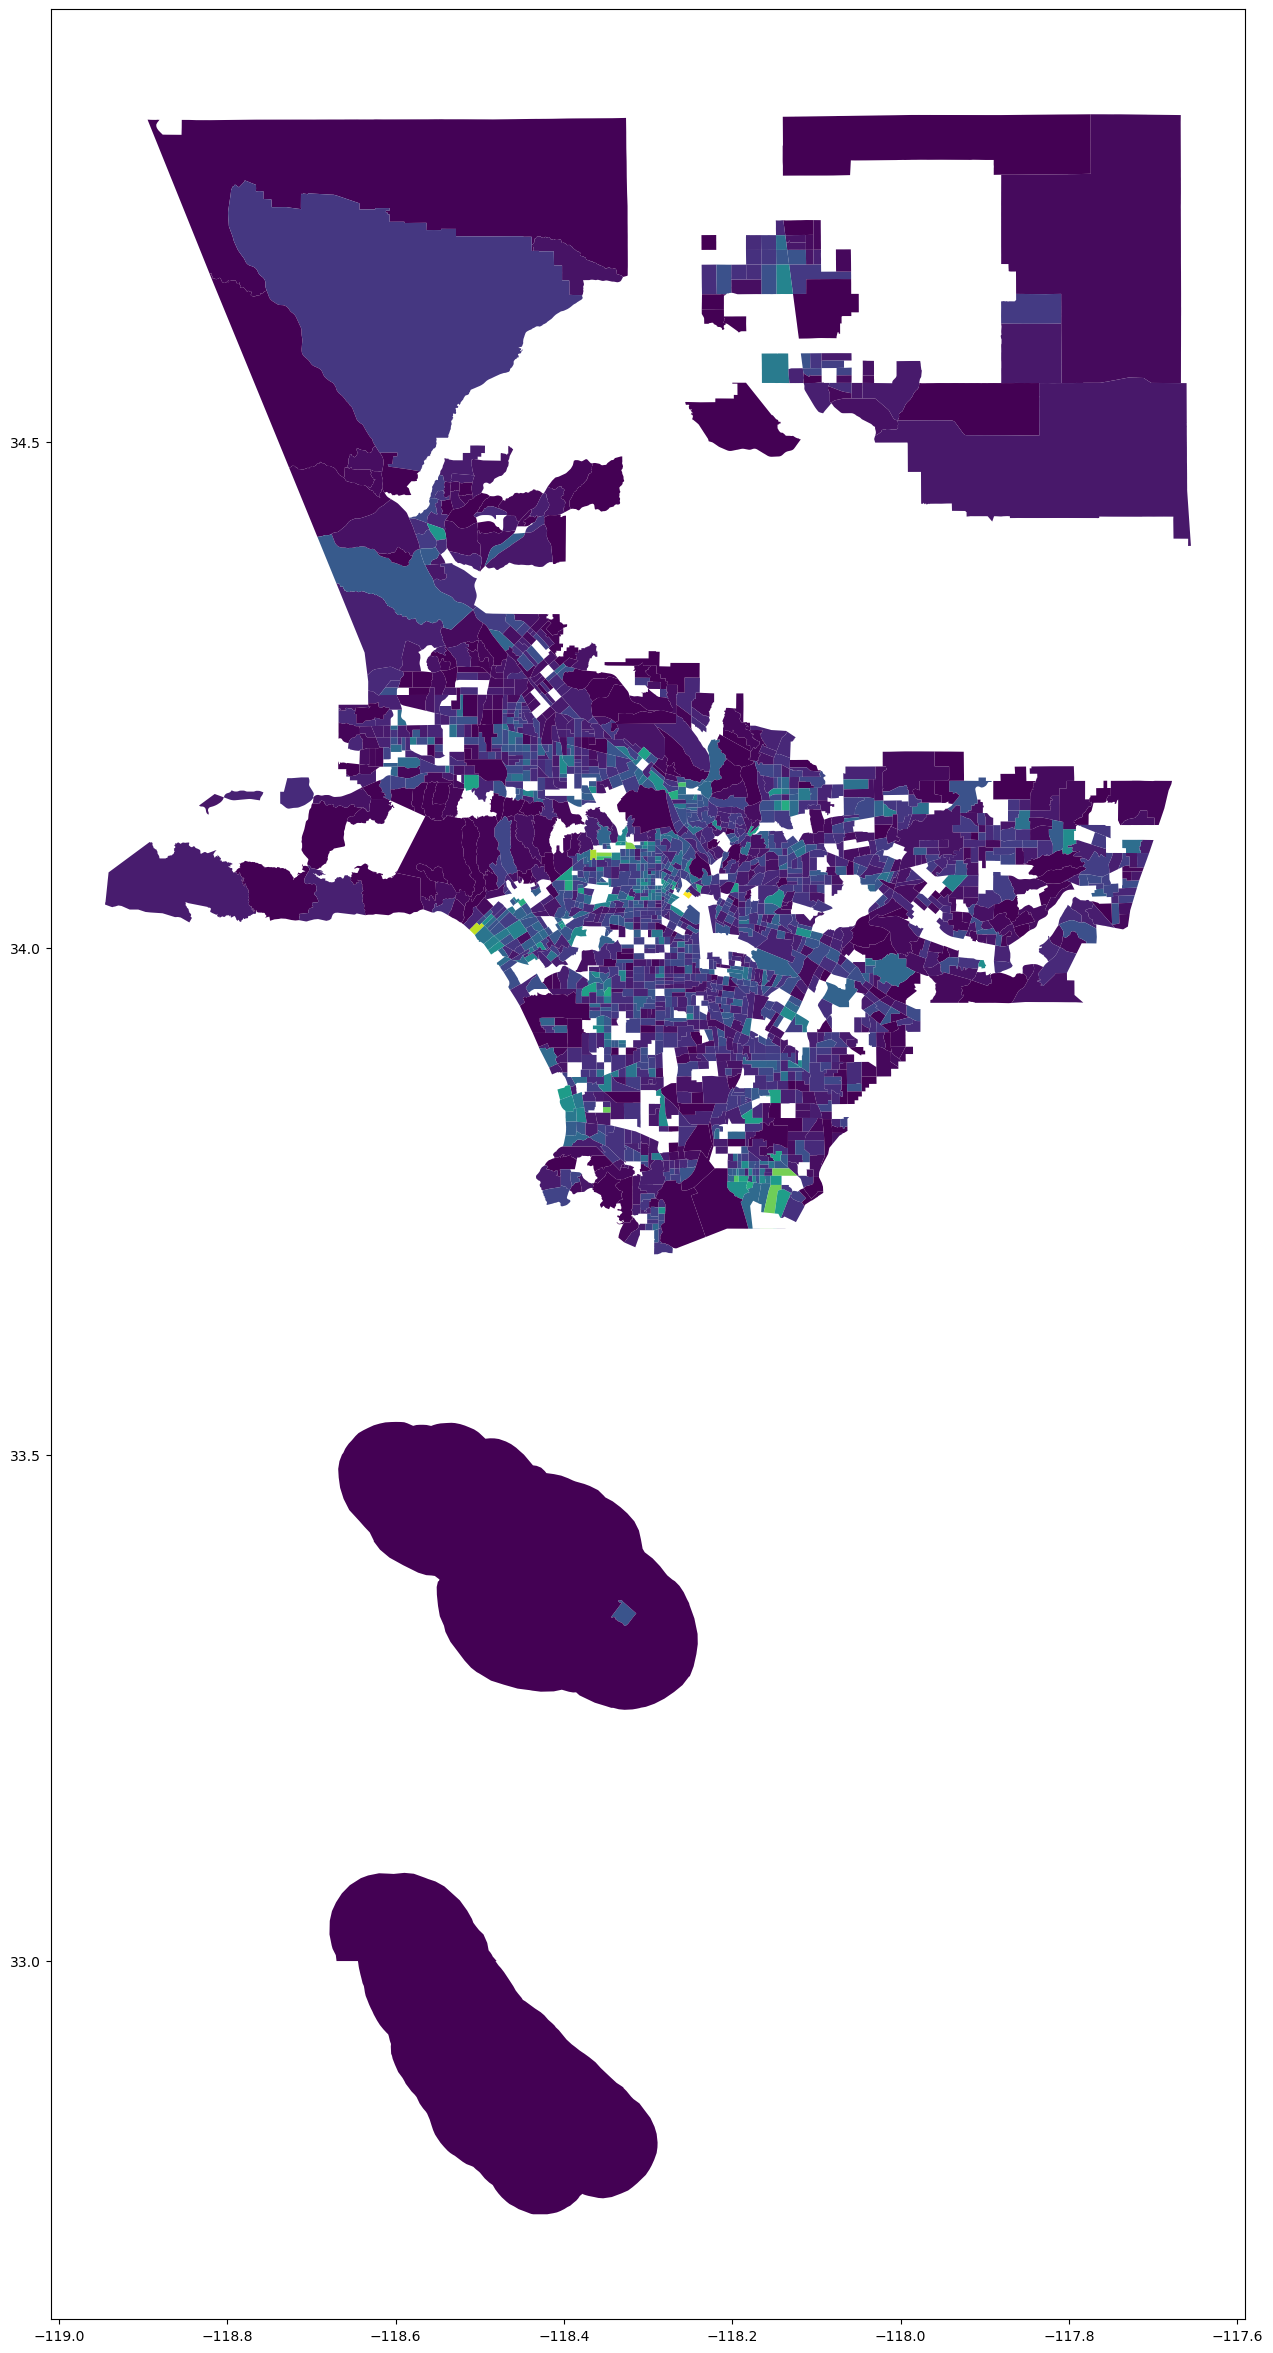

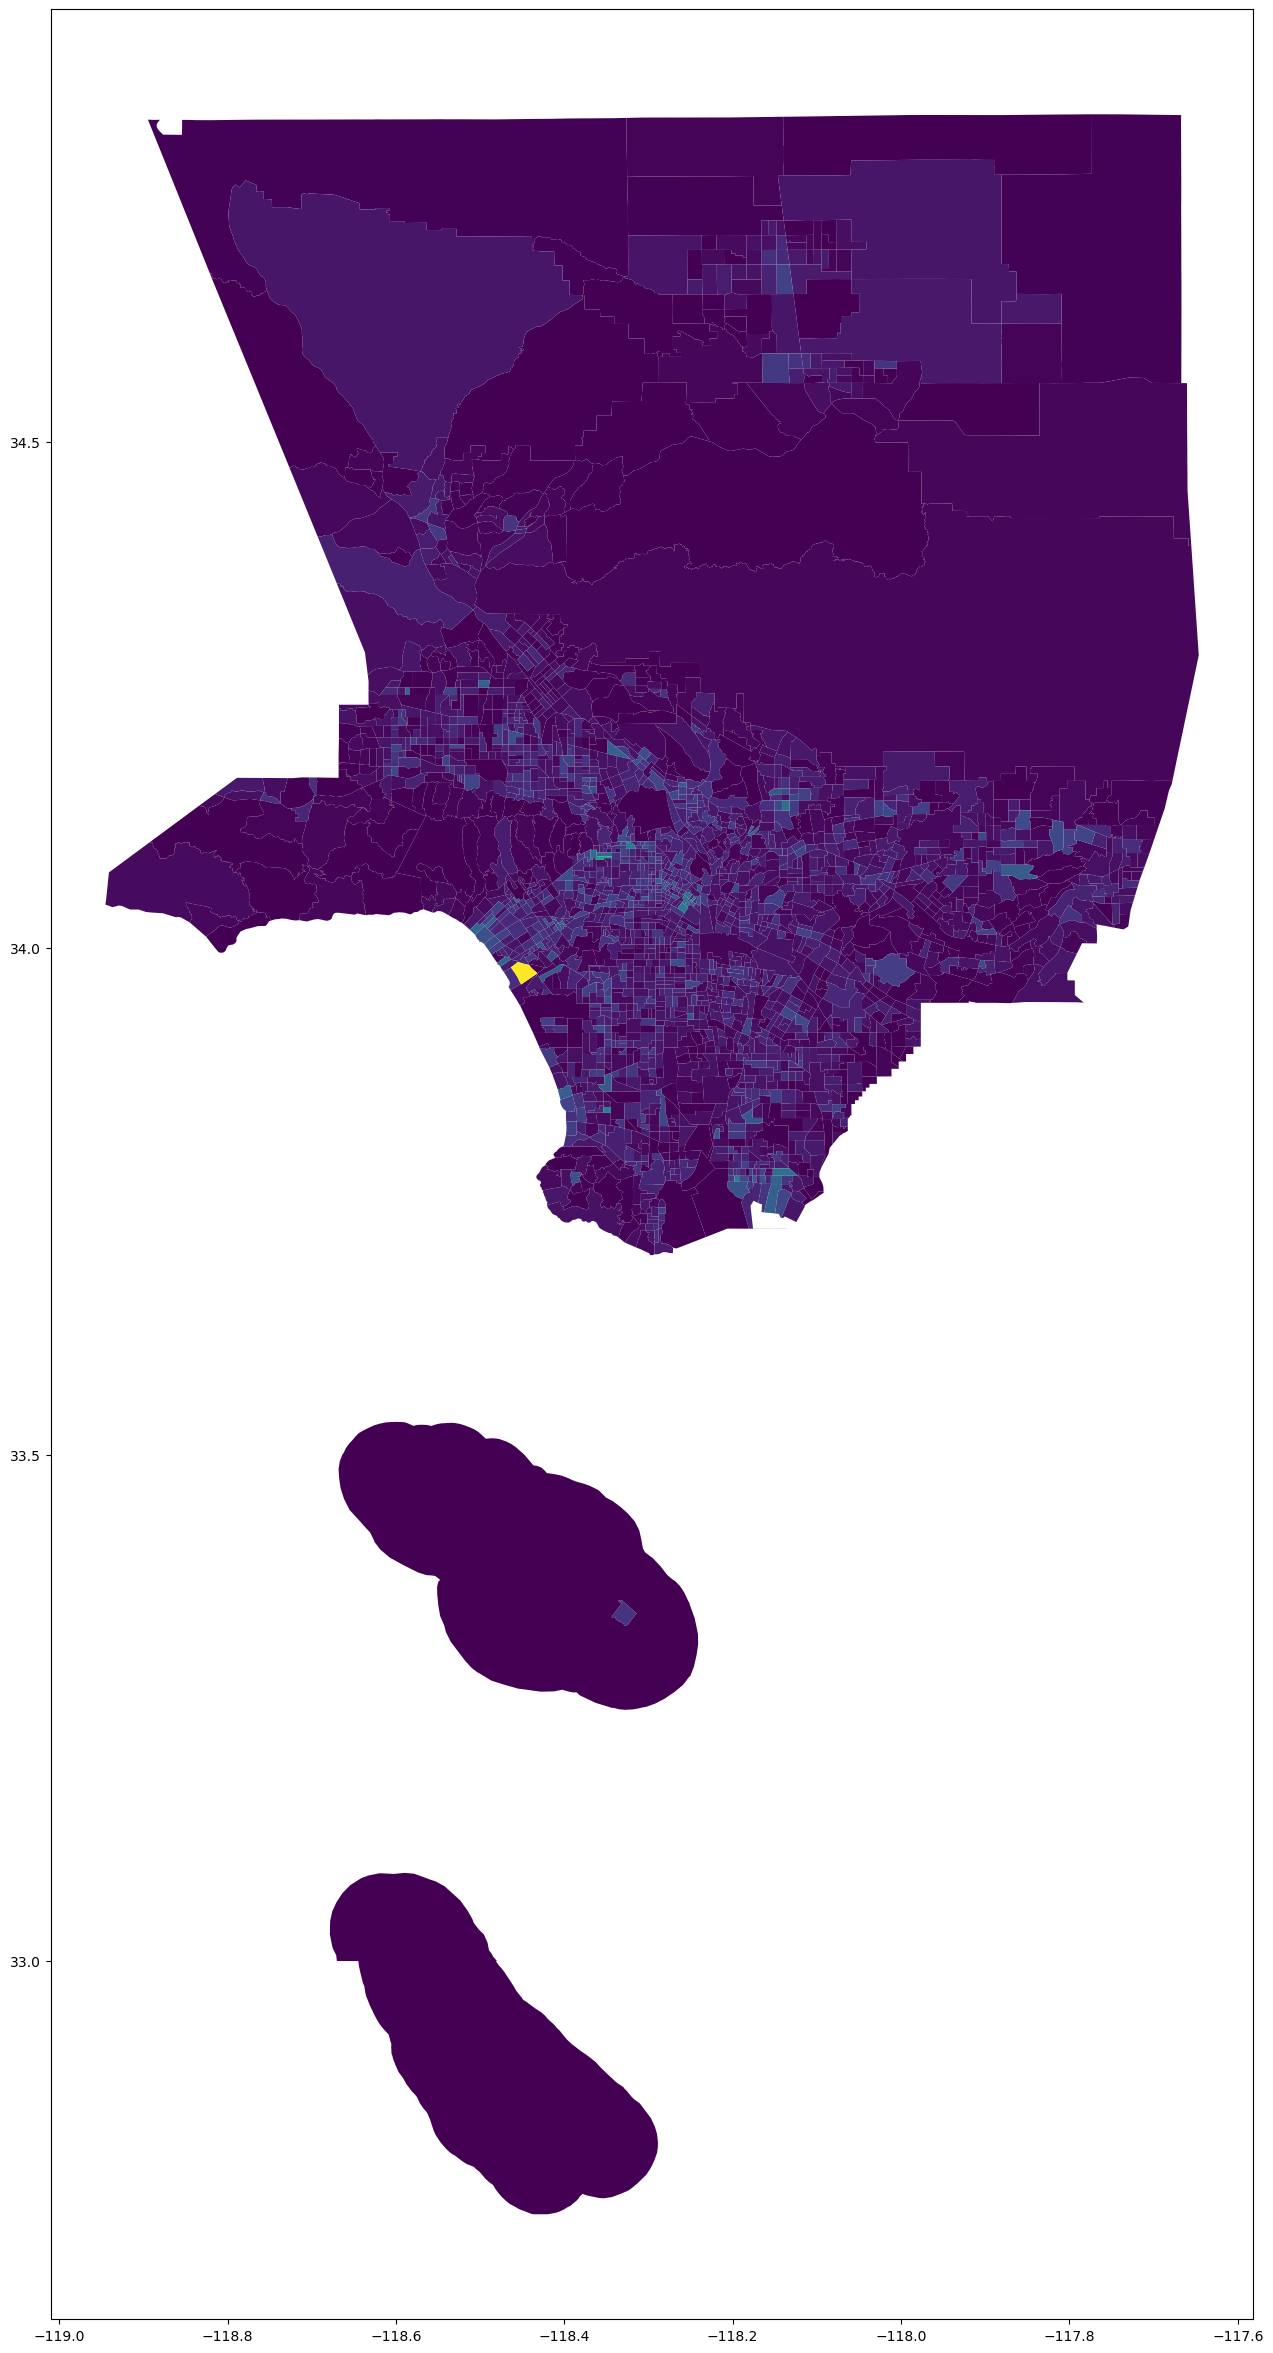

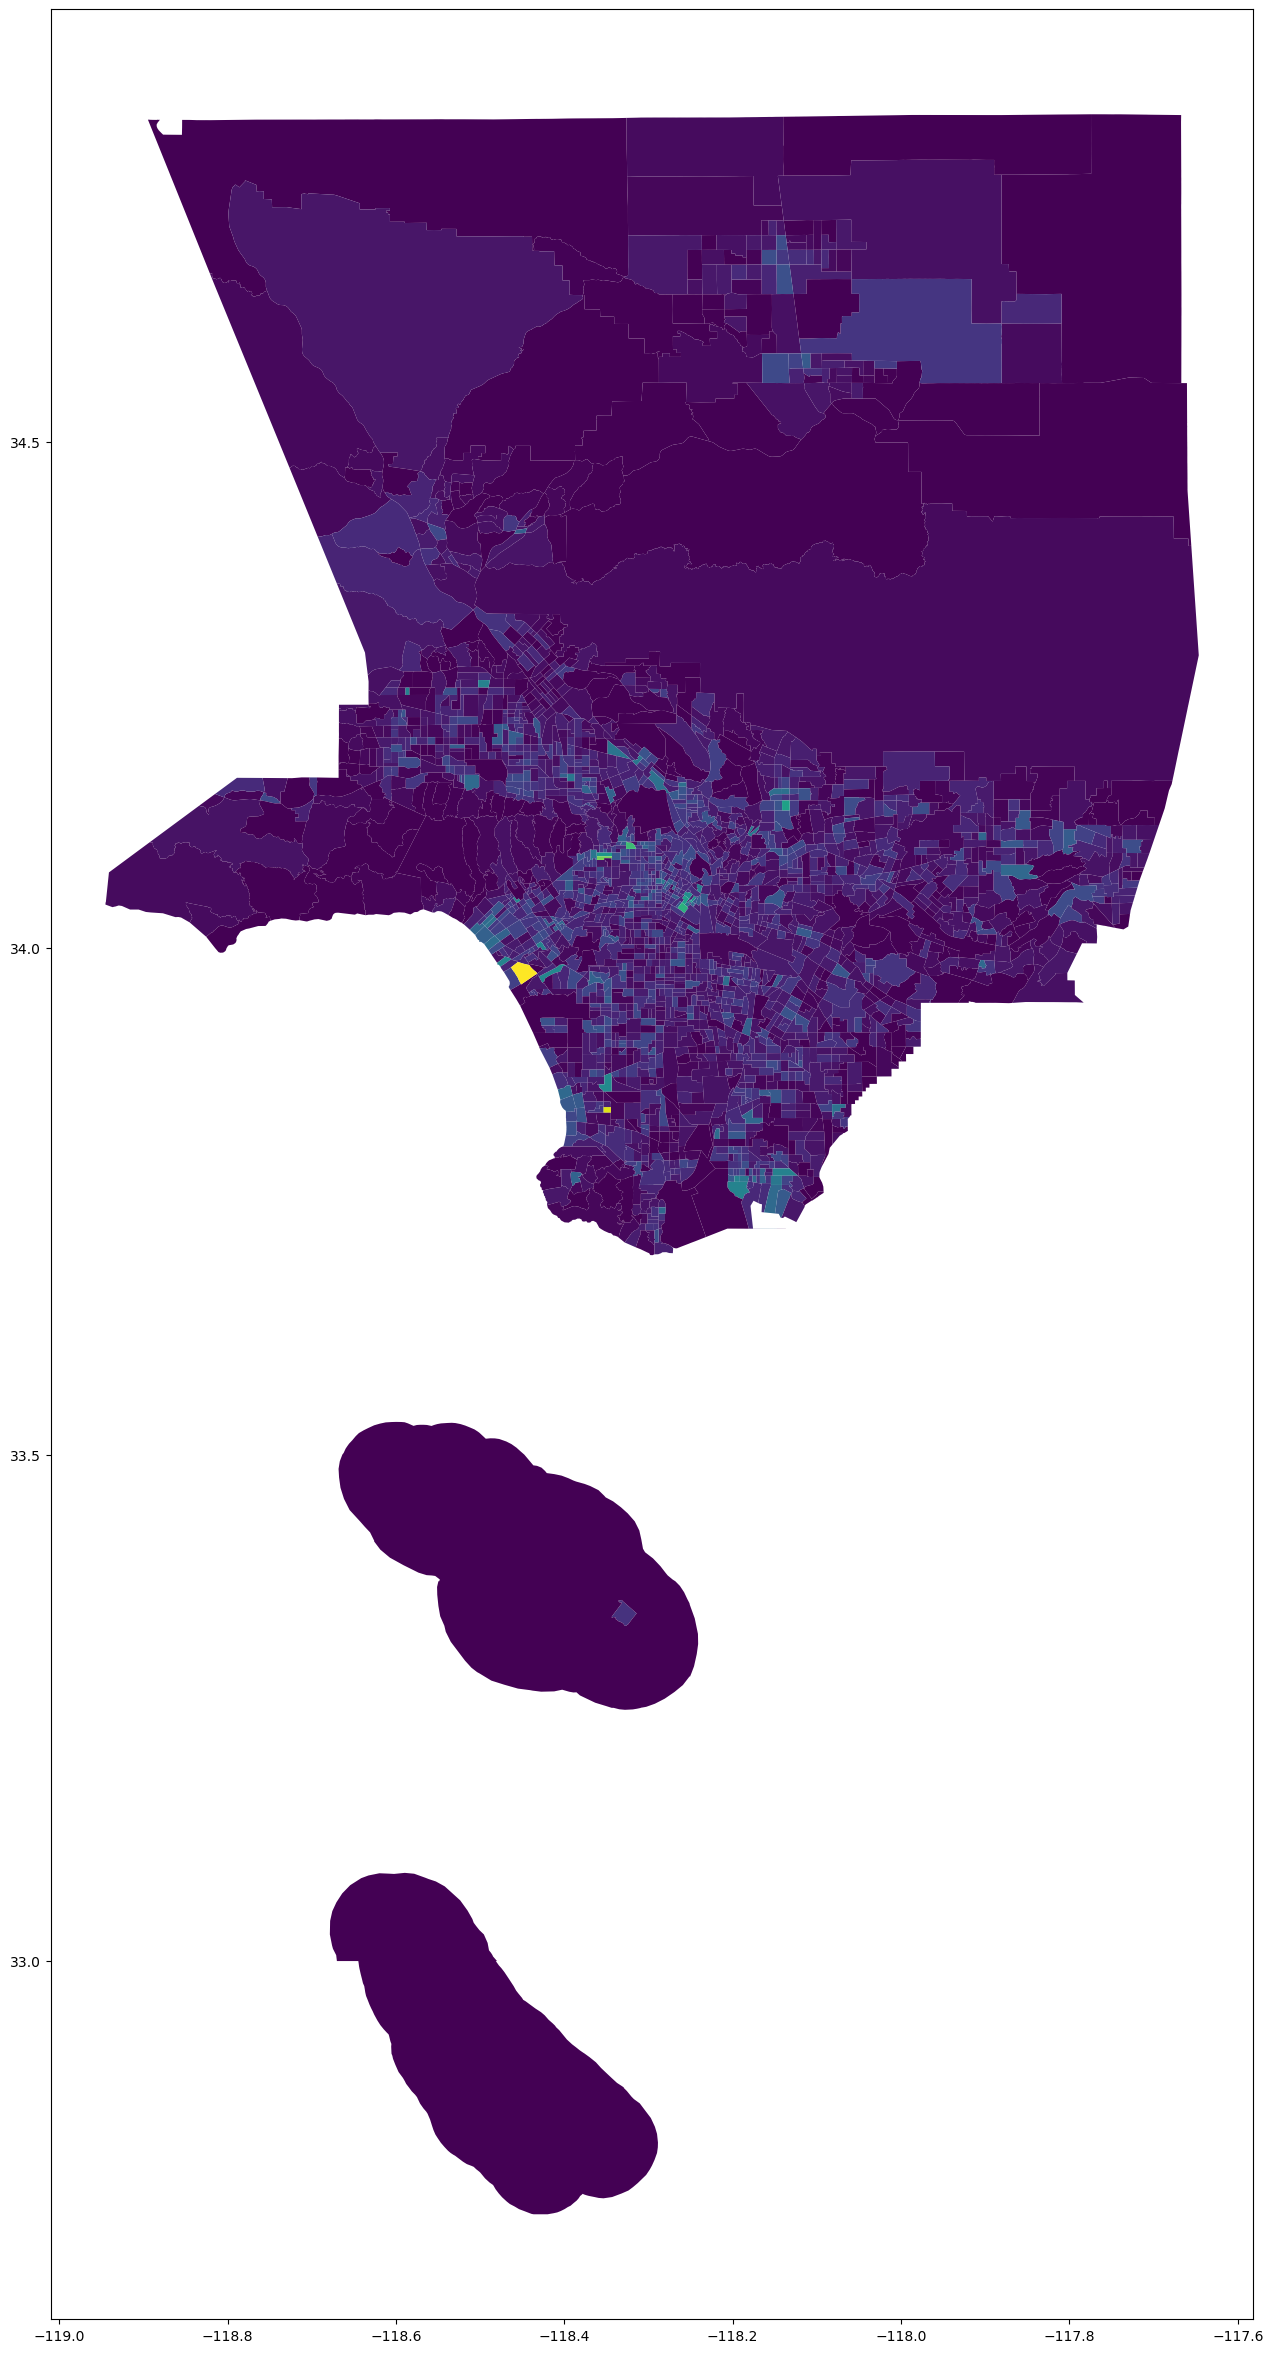

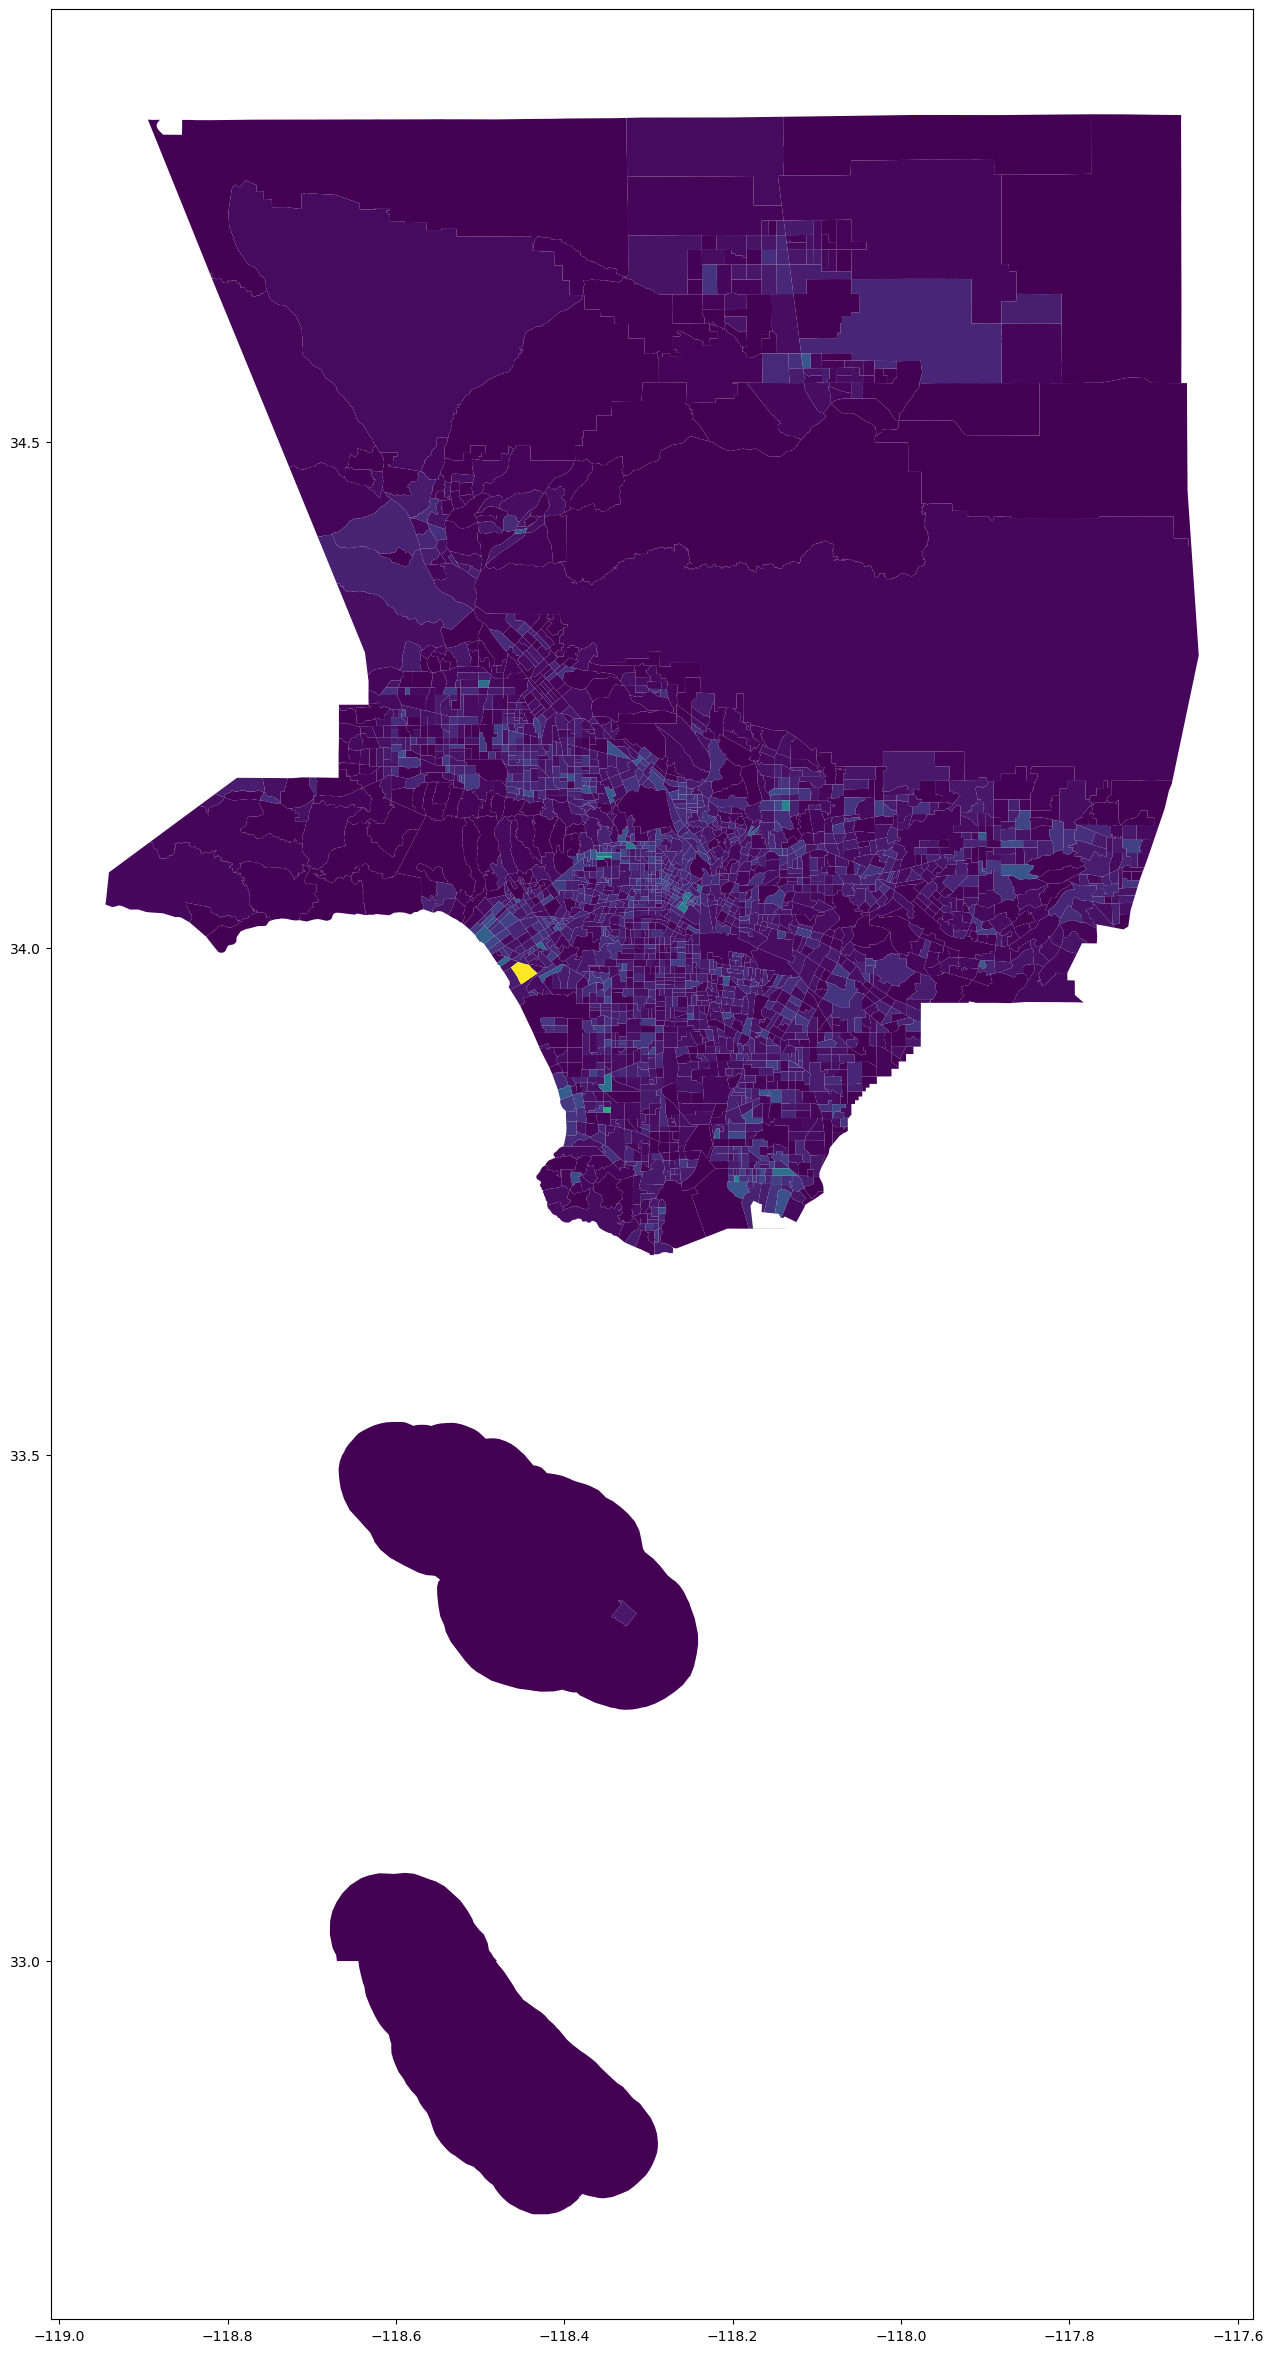

In [36]:
maps_over35 = []
for i in range(9,13,1):
    maps_over35 = s_housing_chara_tracts[i].plot(
        column='GRAPI_more_35',
        figsize=(20,30),
    )
